This notebook implements a minimal reaction-diffusion model that describes nucleoid segregation in *E. coli*, as described in the paper "Polysome formation drives bulk chromosome segregation and couples it to cell growth in *Escherichia coli*" by Papagiannakis et al. (2024). The code achieves the following:
1. simulate and visualize the 1D polysome (blue) and nucleoid (red) dynamics during the cell cycle.
2. study how growth rate affects the timing of nucleoid segregation
3. study how nucleoid mobility ($D_n$) affects the nucleoid asymmetry

In [1]:
%autosave 5

Autosaving every 5 seconds


In [2]:
# impose Dirichlet boundary condition to fix the bulk concentration
from jax import config

config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import lax
import os, argparse, subprocess
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

plt.rcParams.update(
    {
        "mathtext.fontset": "stix",
        "font.family": "STIXGeneral",
        "legend.fontsize": 14,  # this is the font size in legends
        "xtick.labelsize": 14,  # this and next are the font of ticks
        "ytick.labelsize": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 18,  # this is the fonx of axes labels
        "savefig.format": "pdf",  # how figures should be saved
    }
)

linewidth = 2
RdBumap = plt.get_cmap("RdBu")
virimap = plt.get_cmap("viridis")
civimap = plt.get_cmap("cividis")


parser = argparse.ArgumentParser(description="MavQ_4species_V1_1")
parser.add_argument("--L", type=int, default=1, help="rescaled length")
parser.add_argument("--N", type=int, default=128)
parser.add_argument(
    "--kn1", type=float, default=0.003, help="polysome degradation rate"
)
parser.add_argument(
    "--k10", type=float, default=0.002, help="coefficient for polysome production rate"
)


parser.add_argument("--chip", type=float, default=0.2)
parser.add_argument("--chin", type=float, default=0.4)
parser.add_argument("--chinp", type=float, default=1.2)
parser.add_argument("--vn", type=float, default=10.0)
parser.add_argument("--vp", type=float, default=5.0)
parser.add_argument(
    "--lmda", type=float, default=0.03, help="interface width, in micron"
)
parser.add_argument(
    "--Dn",
    type=float,
    default=2e-4,  # this value will be varied
    help="diffusion coefficient of nucleoid, in micron^2/s",
)
parser.add_argument(
    "--Dp",
    type=float,
    default=0.015,
    help="diffusion coefficient of polysomes, in micron^2/s",
)

parser.add_argument("--filename", type=str, default="data_tune_diffusion")
flags = parser.parse_args("")

if os.path.exists(flags.filename):
    os.stat(flags.filename)
else:
    os.makedirs(flags.filename)

## Obtain the relation between initial cell length and growth rate.

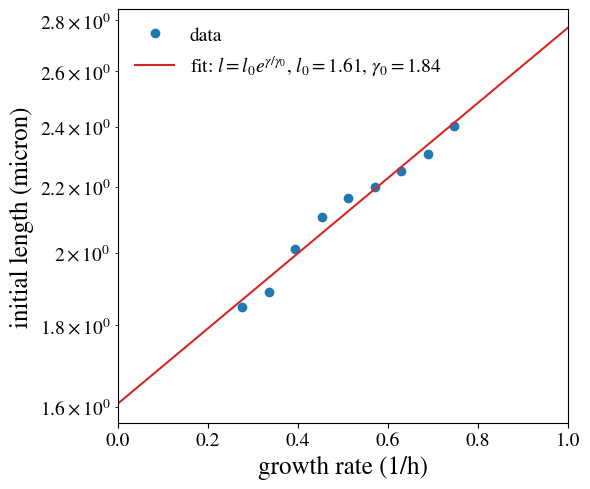

In [3]:
data_length = onp.load(
    "demograph_data_dict_cell_length_growth_rate.npz", allow_pickle=True
)
data_growth_rate = data_length["growth_rate_data"]
data_initial_length = data_length["cell_length_data"]


fitres_length_growth = onp.polyfit(data_growth_rate, onp.log(data_initial_length), 1)
l_init_fun = lambda gr: onp.exp(fitres_length_growth[1] + fitres_length_growth[0] * gr)

fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.plot(data_growth_rate, data_initial_length, "o", color="tab:blue", label="data")
ax.set_yscale("log")

gr_mesh = onp.linspace(0.0, 1.0, 100)
ax.plot(
    gr_mesh,
    onp.exp(fitres_length_growth[1] + fitres_length_growth[0] * gr_mesh),
    color="tab:red",
    label=r"fit: $l=l_0e^{\gamma/\gamma_0}$, "
    + r"$l_0 ={:.2f}$, ".format(onp.exp(fitres_length_growth[1]))
    + r"$\gamma_0={:.2f}$".format(1 / fitres_length_growth[0]),
)

ax.set_xlabel("growth rate (1/h)")
ax.set_ylabel("initial length (micron)")
ax.set_xlim(gr_mesh[0], gr_mesh[-1])
ax.legend(frameon=False)

# fig.savefig(f"{flags.filename}/length_growth_rate_fit.pdf")

## Functions for visualization

In [149]:
# define the grid
dx = 2 * flags.L / flags.N
x_list = np.arange(-flags.L, flags.L, dx) + dx / 2
kx = 2 * np.pi * np.fft.fftfreq(flags.N, d=dx)


def plot_phi(phi, ylims=None):
    fig, ax1 = plt.subplots(figsize=(6, 2), tight_layout=True)
    field_names = ["polysome", "nucleoid"]
    colors = ["tab:blue", "tab:red"]
    ax2 = ax1.twinx()
    ax = [ax1, ax2]
    for i in range(2):
        ax[i].plot(
            x_list,
            phi[i],
            label=field_names[i],
            linewidth=linewidth,
            color=colors[i],
        )
        ax[i].set_ylabel(field_names[i], color=colors[i])
        if ylims is not None:
            ax[i].set_ylim(0, ylims[i])
    ax1.set_xlabel("Relative cell length $x/L$")
    ax1.set_xlim(0, 1)
    return fig, ax


def plot_phi_absolute(phi, l, ylims=None, xlims=None, fig=None, ax=None, ls="-"):
    if fig is None:
        fig, ax1 = plt.subplots(figsize=(6, 2), tight_layout=True)
        ax2 = ax1.twinx()
        ax = [ax1, ax2]
    field_names = ["polysome", "nucleoid"]
    colors = ["tab:blue", "tab:red"]
    for i in range(2):
        ax[i].plot(
            (x_list[flags.N // 2 :] - 0.5) * l,
            phi[i][flags.N // 2 :],
            label=field_names[i],
            linewidth=linewidth,
            color=colors[i],
            linestyle=ls,
        )
        ax[i].set_ylabel(field_names[i], color=colors[i])
        if ylims is not None:
            ax[i].set_ylim(0, ylims[i])
    ax[0].set_xlabel("Cell length ($\mu m$)")
    for i in range(2):
        if xlims is not None:
            ax[i].set_xlim(xlims)
            ax[i].axvline(l / 2, color="k", linestyle="--")
            ax[i].axvline(-l / 2, color="k", linestyle="--")
        else:
            ax[i].set_xlim(-l / 2, l / 2)
    return fig, ax

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mq/p5kn27bn3j927psc4z_49npm0000gn/T/ipykernel_70996/3206643094.py:48: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("Cell length ($\mu m$)")


# Run phase field simulations

Define the range of growth rates and nucleoid mobilities to be studied.

In [5]:
gamma_list = onp.linspace(0.25, 1.0, 6)[::-1]
T_list = onp.log(2) / gamma_list * 60 * 60
l_init_list = l_init_fun(gamma_list)
l_final_list = l_init_list * 2

Dn_list = onp.array([3e-4, 5e-4, 1e-3, 5e-3])

Define the name of the output folder where the simulation results will be saved.

In [6]:
filename_all = [
    [
        flags.filename
        + "/"
        + f"Dp_{flags.Dp}_Dn_{Dn}/"
        + f"scan_T_{T_list[T_id]/60:.0f}/"
        for T_id in range(len(T_list))
    ]
    for Dn in Dn_list
]

for Dn_id in range(len(Dn_list)):
    for T_id in range(len(T_list)):
        if os.path.exists(filename_all[Dn_id][T_id]):
            os.stat(filename_all[Dn_id][T_id])
        else:
            os.makedirs(filename_all[Dn_id][T_id])

Define the polysome production rate for different growth rates.

In [7]:
gamma_seconds = gamma_list / 60 / 60
k1_list = flags.k10 * (1 + gamma_seconds / flags.kn1)

Run phase field simulations for all growth rates and nucleoid mobilities.

In [9]:
def run_external_script(script_path, params):
    # Example: Running an external Python script
    command = ["python", script_path, *params.split()]
    subprocess.run(command, check=True)


def run_scripts_with_limit(script_path, script_params, max_workers):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for params in script_params:
            future = executor.submit(run_external_script, script_path, params)
            futures.append(future)

        # Use tqdm to create a progress bar
        with tqdm(total=len(script_params)) as pbar:
            for future in as_completed(futures):
                try:
                    future.result()  # Ensure any exceptions in the subprocess are propagated
                except Exception as e:
                    print(f"Subprocess error: {e}")
                pbar.update(1)  # Update progress bar for each completed task

In [10]:
default_parameters = {
    "L": flags.L,
    "N": flags.N,
    "kn1": flags.kn1,
    "chip": flags.chip,
    "chin": flags.chin,
    "chinp": flags.chinp,
    "Vn": flags.vn,
    "Vp": flags.vp,
    "lmda": flags.lmda,
    "Dp": flags.Dp,
    "phi-center-p": 0.02,
    "phi-boundary-n": 0.02,
    "phi-center-n": 0.6,
    "phi-boundary-p": 0.2,
    "l-center": 0.15,
}

default_parameters_str = " ".join(
    [f"--{key} {value}" for key, value in default_parameters.items()]
)

script_path = "polysome_phase_field.py"
script_params = [
    f"--T {T_list[T_id]} --l-init {l_init_list[T_id]} --l-final {l_final_list[T_id]} --Dn {Dn_list[Dn_id]} --filename {filename_all[Dn_id][T_id]} {default_parameters_str} --k1 {k1_list[T_id]}"
    for T_id in range(len(T_list))
    for Dn_id in range(len(Dn_list))
]

max_concurrent_processes = 16  # Adjust as needed
run_scripts_with_limit(script_path, script_params, max_concurrent_processes)

100%|██████████| 24/24 [02:26<00:00,  6.10s/it]


# Visualize the dynamics of polysome and nucleoid during the cell cycle

As in the paper, we consider $\gamma=0.25$ and $D_n=0.001$.

In [44]:
gamma_id = 5
Dn_id = 2

print(f"gamma = {gamma_list[gamma_id]}", f"Dn = {Dn_list[Dn_id]}")

gamma = 0.25 Dn = 0.001


In [45]:
data = np.load(filename_all[Dn_id][gamma_id] + "phi_grow.npz")
t_trace = data["t_trace"]
phi_trace = data["phi_trace"]

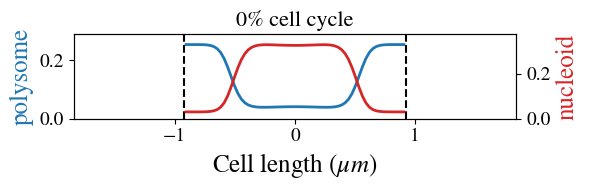

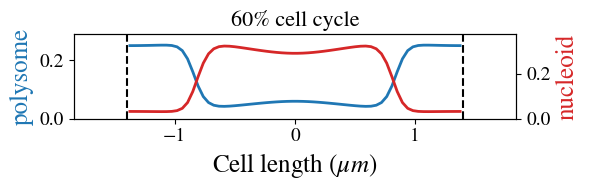

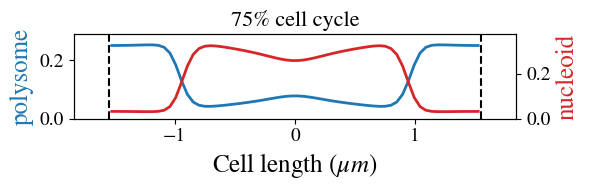

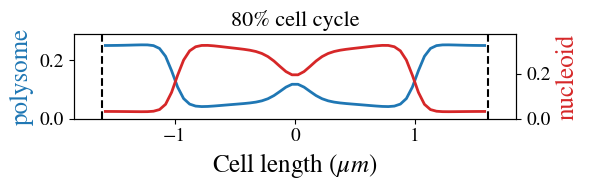

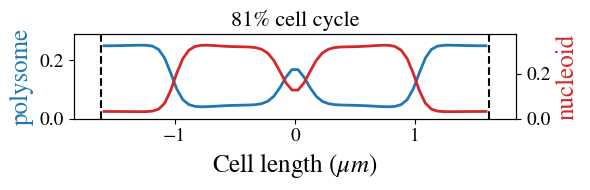

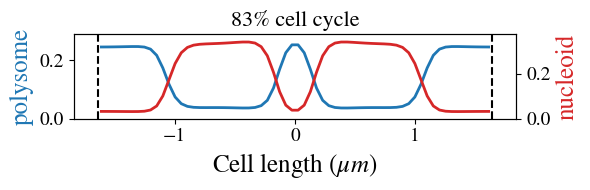

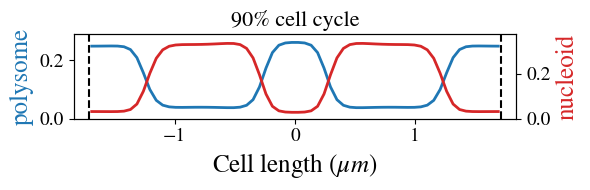

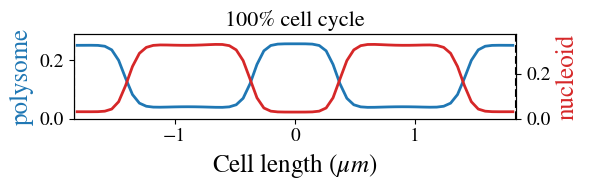

In [73]:
relative_cell_cycle_thresholds = onp.array([0, 0.6, 0.75, 0.8, 0.81, 0.83, 0.9, 1.0])
t_ids = onp.searchsorted(t_trace, t_trace[-1] * relative_cell_cycle_thresholds)
ylims = phi_trace.max(axis=(0, 2)) * 1.1
xlims = (-l_final_list[gamma_id] / 2, l_final_list[gamma_id] / 2)


for plot_id in range(len(relative_cell_cycle_thresholds)):
    fig, ax = plot_phi_absolute(
        phi_trace[t_ids[plot_id]],
        l_init_list[gamma_id]
        * np.exp(gamma_list[gamma_id] * t_trace[t_ids[plot_id]] / 60 / 60),
        xlims=xlims,
        ylims=ylims,
    )
    ax[0].set_title(f"{t_trace[t_ids[plot_id]]/T_list[gamma_id]*100:.0f}% cell cycle")

# Plot the relative splitting time as a function of growth rate

In [75]:
Dn_id = 2

print(f"Dn = {Dn_list[Dn_id]}")

Dn = 0.001


In [97]:
segregation_threshold = 0.1

t_rel = onp.zeros(gamma_list.shape[0])
for gamma_id in range(gamma_list.shape[0]):
    data = np.load(filename_all[Dn_id][gamma_id] + "phi_grow.npz")
    t_trace = data["t_trace"]
    phi_trace = data["phi_trace"]
    t_seg = onp.argmax(phi_trace[:, 1, flags.N // 4 * 3] < segregation_threshold)
    t_rel[gamma_id] = t_trace[t_seg] / T_list[gamma_id]

Text(0, 0.5, 'Relative cell division cycle time at \n nucleoid splitting (%)')

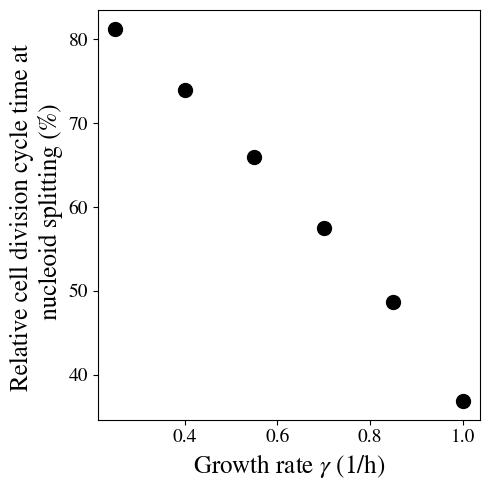

In [105]:
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)

ax.plot(gamma_list, t_rel * 100, "o", color="k", ms=10)
ax.set_xlabel(r"Growth rate $\gamma$ (1/h)")
ax.set_ylabel("Relative cell division cycle time at \n nucleoid splitting (%)")

# Plot the polysome or nucleoid profiles at newborn cells to demonstrate how asymmetry depends on nucleoid mobility

Take the final concentration profile of the above simulations, divide the cell in half, and simulate for another cell cycle.

In [118]:
for gamma_id in range(len(gamma_list)):
    for Dn_id in range(len(Dn_list)):
        phi_final = np.load(filename_all[Dn_id][gamma_id] + "phi_grow.npz")[
            "phi_trace"
        ][-1]
        phi_divided = np.array(
            [np.interp(x_list, x_list * 2, phi_final[i]) for i in range(2)]
        )
        np.savez(
            filename_all[Dn_id][gamma_id] + "phi_divided.npz",
            phi_init=phi_divided,
        )

In [121]:
script_path = "polysome_phase_field.py"
script_params = [
    f"--T {T_list[T_id]} --l-init {l_init_list[T_id]} --l-final {l_final_list[T_id]} --Dn {Dn_list[Dn_id]} --filename {filename_all[Dn_id][T_id] + 'asymmetric_'} {default_parameters_str} --k1 {k1_list[T_id]} --init-name {filename_all[Dn_id][T_id] + 'phi_divided.npz'}"
    for T_id in range(len(T_list))
    for Dn_id in range(len(Dn_list))
]

max_concurrent_processes = 16  # Adjust as needed
run_scripts_with_limit(script_path, script_params, max_concurrent_processes)

100%|██████████| 24/24 [01:17<00:00,  3.23s/it]


## visualize the concentration profiles

In [122]:
gamma_id = 0
print(f"gamma = {gamma_list[gamma_id]}")

gamma = 1.0


In [155]:
phi_symmetric_all = []
phi_asymmetric_all = []
for Dn_id in range(len(Dn_list)):
    data = np.load(filename_all[Dn_id][gamma_id] + "phi_grow.npz")
    phi_symmetric_all.append(data["phi_trace"][0])
    data = np.load(filename_all[Dn_id][gamma_id] + "asymmetric_phi_grow.npz")
    phi_asymmetric_all.append(data["phi_trace"][0])

phi_symmetric_all = np.array(phi_symmetric_all)
phi_asymmetric_all = np.array(phi_asymmetric_all)

xlims = (-l_final_list[gamma_id] / 2, l_final_list[gamma_id] / 2)
ylims = np.maximum(
    phi_asymmetric_all.max(axis=(0, 2)) * 1.1, phi_symmetric_all.max(axis=(0, 2)) * 1.1
)

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mq/p5kn27bn3j927psc4z_49npm0000gn/T/ipykernel_70996/276658228.py:21: SyntaxWarning: invalid escape sequence '\m'
  axs[0][len(Dn_list) - 1 - Dn_id].set_title(f"$D_n = {Dn_list[Dn_id]} \mu m^2/s$")


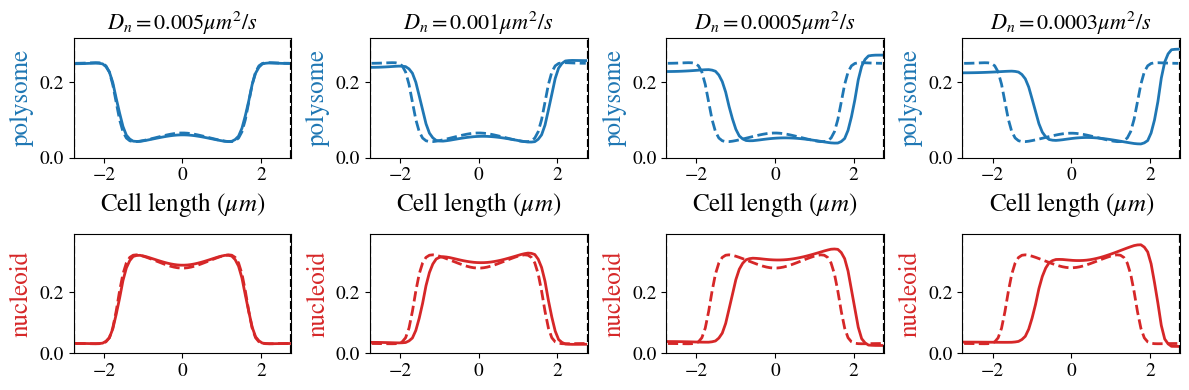

In [157]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4), tight_layout=True)
for Dn_id in range(len(Dn_list)):
    plot_phi_absolute(
        phi_symmetric_all[Dn_id],
        l_final_list[gamma_id],
        xlims=xlims,
        ylims=ylims,
        fig=fig,
        ax=[axs[0][len(Dn_list) - 1 - Dn_id], axs[1][len(Dn_list) - 1 - Dn_id]],
        ls="--",
    )
    plot_phi_absolute(
        phi_asymmetric_all[Dn_id],
        l_final_list[gamma_id],
        xlims=xlims,
        ylims=ylims,
        fig=fig,
        ax=[axs[0][len(Dn_list) - 1 - Dn_id], axs[1][len(Dn_list) - 1 - Dn_id]],
        ls="-",
    )
    axs[0][len(Dn_list) - 1 - Dn_id].set_title(f"$D_n = {Dn_list[Dn_id]} \mu m^2/s$")